# The Sparks Foundation

## Data Science and Business Analytics

### Stock Market Prediction using Numerical and Textual Analysis - By Sabyasachi Seal

## Importing the libraries

In [23]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.layers import Dense, LSTM
from keras.models import Sequential
import matplotlib.pyplot as plt
from sklearn import metrics 
import pandas as pd 
import numpy as np
import math

## Loading and Testing Stock Market Dataset

In [24]:
df_prices = pd.read_csv('Datasets/stockprices.csv')
df_prices.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,26.010000,26.379999,25.860001,25.900000,24.324486,55900
1,2017-03-02,25.830000,25.920000,25.660000,25.770000,24.202393,41800
2,2017-03-03,25.780001,26.070000,25.459999,25.780001,24.211786,70400
3,2017-03-06,25.680000,25.889999,25.440001,25.830000,24.258745,42600
4,2017-03-07,25.700001,25.879999,25.549999,25.840000,24.268139,45600


## Loading and Testing News Dataset

In [25]:
cols = ['Date', 'Category', 'News']
df_news = pd.read_csv("Datasets/news.csv", names=cols)
df_news = df_news.dropna(axis=0, how='any')
df_news

,Date,Category,News
0,20010102,unknown,Status quo will not be disturbed at Ayodhya; s...
1,20010102,unknown,Fissures in Hurriyat over Pak visit
2,20010102,unknown,America's unwanted heading for India?
3,20010102,unknown,For bigwigs; it is destination Goa
4,20010102,unknown,Extra buses to clear tourist traffic
...,...,...,...
149995,20021015,india,Post polls; India cringes as Pak finds acceptance
149996,20021015,india,Bangladesh is al-Qaeda's new haven: Time
149997,20021015,india,Hawk deal not finalised yet: India to UK
149998,20021015,city.kolkata,A helping hand to clear clinical waste


## Cleaning Data - Dropping Unwanted Values (NaN)

In [26]:
df_news.drop(0, inplace=True)
df_news.drop('Category', axis=1, inplace=True)
df_news

,Date,News
1,20010102,Fissures in Hurriyat over Pak visit
2,20010102,America's unwanted heading for India?
3,20010102,For bigwigs; it is destination Goa
4,20010102,Extra buses to clear tourist traffic
5,20010102,Dilute the power of transfers; says Riberio
...,...,...
149995,20021015,Post polls; India cringes as Pak finds acceptance
149996,20021015,Bangladesh is al-Qaeda's new haven: Time
149997,20021015,Hawk deal not finalised yet: India to UK
149998,20021015,A helping hand to clear clinical waste


## Preprocessing - Coneverting the 'Date' columns to Datetime

In [29]:
df_news['Date'] = pd.to_datetime(df_news['Date'], format='%Y%m%d')
df_prices['Date'] = pd.to_datetime(df_prices.Date, format='%Y-%m-%d')
df_prices

,Date,Open,High,Low,Close,Adj Close,Volume
0,2017-03-01,26.010000,26.379999,25.860001,25.900000,24.324486,55900
1,2017-03-02,25.830000,25.920000,25.660000,25.770000,24.202393,41800
2,2017-03-03,25.780001,26.070000,25.459999,25.780001,24.211786,70400
3,2017-03-06,25.680000,25.889999,25.440001,25.830000,24.258745,42600
4,2017-03-07,25.700001,25.879999,25.549999,25.840000,24.268139,45600
...,...,...,...,...,...,...,...
1254,2022-02-22,49.080002,50.540001,48.970001,49.490002,49.490002,107200
1255,2022-02-23,50.099998,50.320000,49.049999,49.480000,49.480000,125300
1256,2022-02-24,48.349998,49.709999,47.070000,48.980000,48.980000,189600
1257,2022-02-25,49.310001,50.369999,47.529999,50.340000,50.340000,136900


## Plotting the Data 

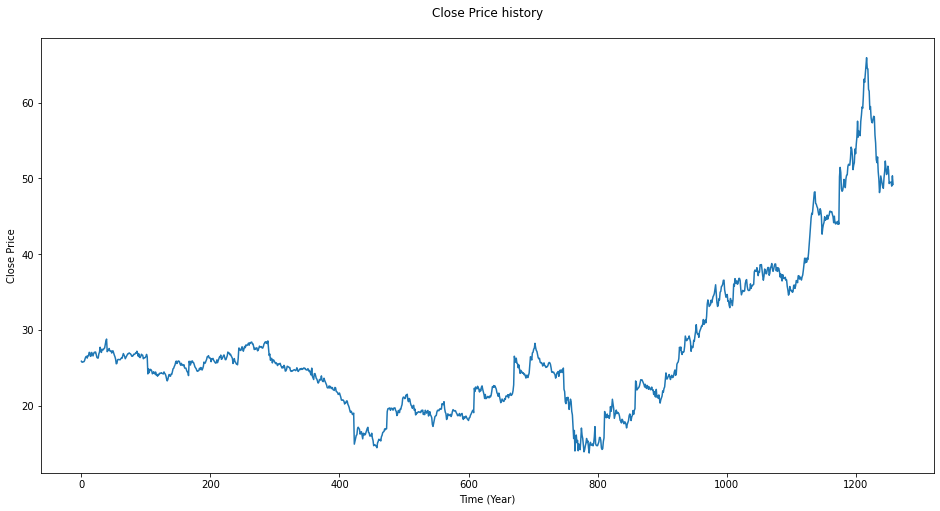

In [30]:
plt.figure(figsize=(16,8))
plt.title('Close Price history\n')
plt.xlabel('Time (Year)')
plt.ylabel('Close Price')
plt.plot(df_prices['Close'])